# Basic Non local means
* adapting to poisson noise
    * use altered version of NLM or checkout bilateral filter
* comparing image quality
* comparing time of execution
    * using cProfile
    * What window size to use? How many surrounding images to use?
    
## Next
* implement the NLM "between" filter
    * check if there is a needed adaptation for poisson noise
* implement/try out the bilateral filter
    * maybe check for other filters
* profile 3 NLM filters and the one bilateral
    * how to choose the correct parameters? 
    * maybe try some statistical method to find optimum between *time* and *quality*
* how to find the ground truth? (is there any?)
    * when taking mean of all images, be careful of the little shift

# IDEAS
* generate 10-15 images with random (gauss) noise
* use default NLM
* use gauss avg from other images
* understand the pseudocode
* possibly implement new NLM
* use multi NLM

Some useful links:
* improving NLM http://web.math.princeton.edu/~nsharon/Nir_Sharon_page/Improved_NLM.html
* NLM from OpenCV https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

Some ideas/questions:
* how big patches they use for the similarity window?

In [1]:
# Main inspiration for this:
# https://docs.opencv.org/3.4/d5/d69/tutorial_py_non_local_means.html

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
prefix = "C:\\Users\\marti\\SCHOOL\\pv162-project\\data\\"

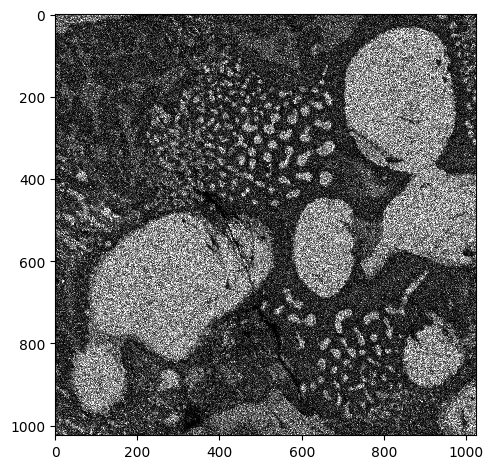

In [123]:
img = cv.imread(prefix + "img_1.png", 0)
imshow(img)

In [27]:
def runSingleDenoising(img):
    single_out1 = cv.fastNlMeansDenoising(img, None, 30, 117)
    single_out2 = cv.fastNlMeansDenoising(img, None, 40, 13, 17)
    return [single_out1, single_out2]


(<Axes: >, <matplotlib.image.AxesImage at 0x2a00e5778e0>)

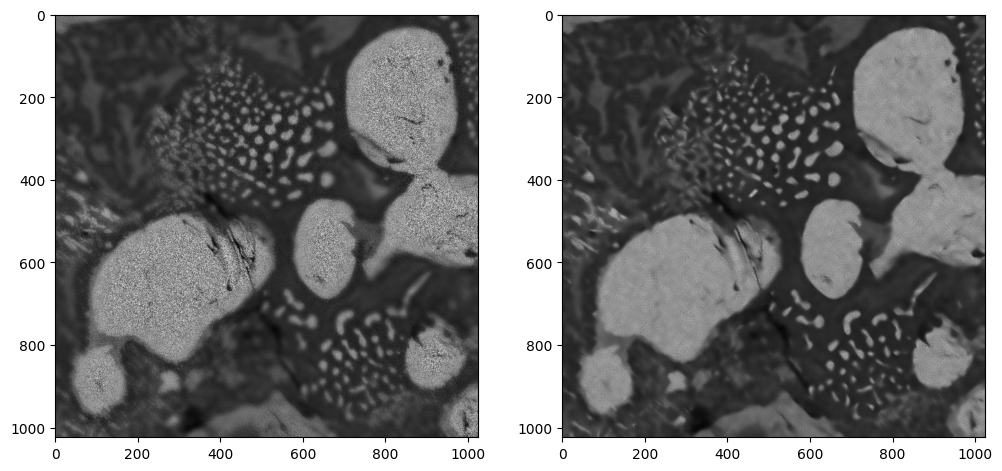

In [31]:
single = runSingleDenoising(img)

plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(single[0])
plt.subplot(122), plt.imshow(single[1])
plt.show()

## Multi Image approach

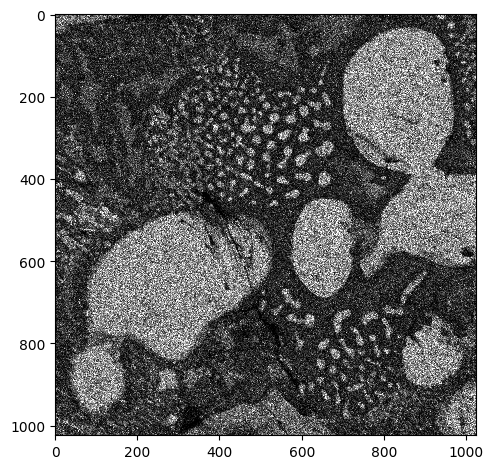

In [126]:
n = 5 # should be odd, and the denoised img should be in the middle
images = [cv.imread(prefix + "img_" + str(i + 1) + ".png", 0) for i in range(n)]
imshow(images[n // 2])

In [22]:
def runMultiDenoising(images, n):
    multi_out1 = cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 30, 117)
    multi_out2 = cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 40, 13, 17)
    
    return [multi_out1, multi_out2]

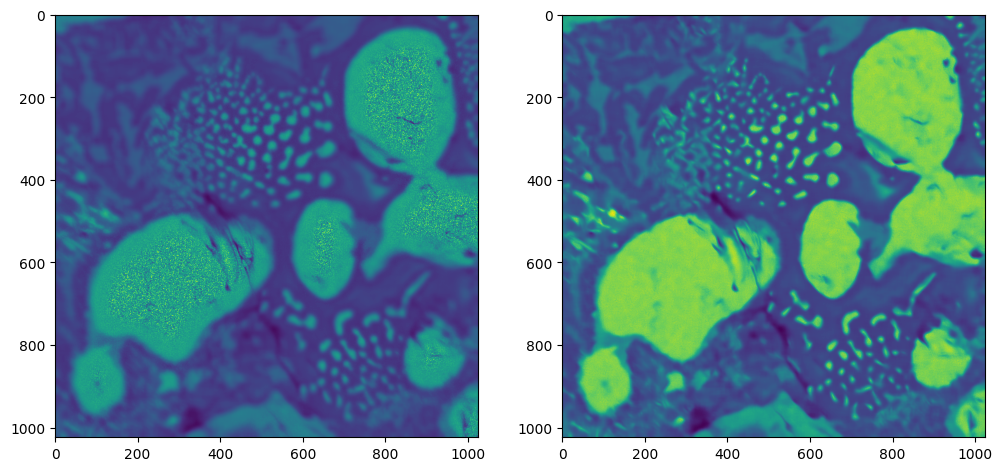

In [127]:
# Denoise 3rd frame considering all the 5 frames
# multi_out1 = cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 30, 117)
# multi_out2 = cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 40, 13, 17)
# imshow(dst)

multi = runMultiDenoising(images, n)

plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(multi[0])
plt.subplot(122), plt.imshow(multi[1])
plt.show()

## Denoised Image Comparison
https://iopscience.iop.org/article/10.1088/1742-6596/1846/1/012069/pdf


IMPORTANT try out a bilateral filter:
https://www.sciencedirect.com/science/article/pii/S1877050916002180

In [148]:
# simulated GROUND TRUTH by mean
# NO SHIFTING PERFORMED
img_ground_truth = np.mean(
    [cv.imread(prefix + "img_" + str(i + 1) + ".png", 0).astype(np.float64) for i in range(45)]
    , axis=0
)

n = 5
fst_img = np.floor(cv.imread(prefix + "img_1.png", 0)).astype(np.uint8)
single_out = np.floor(cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 40, 13, 17)).astype(np.uint8)
multi_out = np.floor(cv.fastNlMeansDenoising(img, None, 40, 13, 17)).astype(np.uint8)
img_ground_truth = np.floor(img_ground_truth).astype(np.uint8)
# print(img_ground_truth.shape)
# imshow(img_ground_truth)

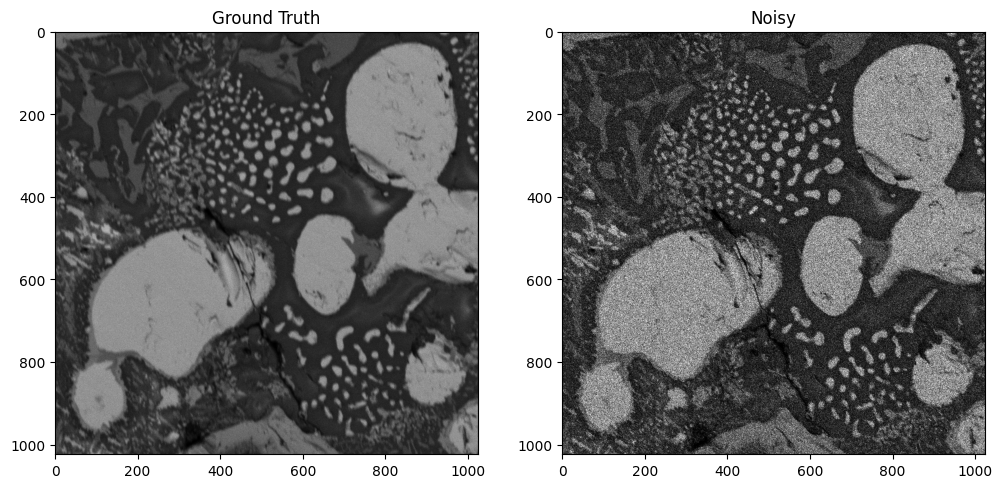

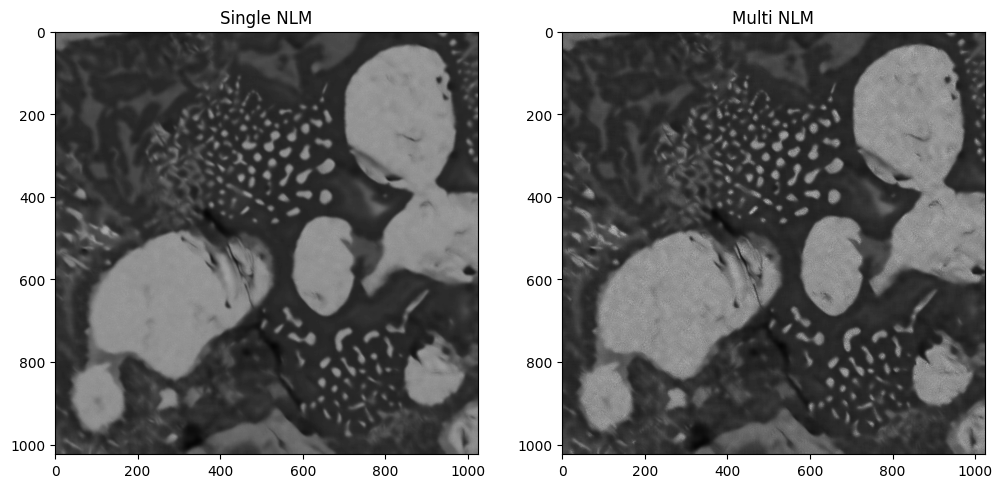

In [153]:
plt.figure(figsize=(12,6))
plt.subplot(121).title.set_text('Ground Truth'), plt.imshow(img_ground_truth, cmap='gray', vmin=0, vmax=255) 
plt.subplot(122).title.set_text('Noisy'), plt.imshow(fst_img, cmap='gray', vmin=0, vmax=255)
plt.show()

plt.figure(figsize=(12,6))
plt.subplot(121).title.set_text('Single NLM'), plt.imshow(single_out, cmap='gray', vmin=0, vmax=255)
plt.subplot(122).title.set_text('Multi NLM'), plt.imshow(multi_out, cmap='gray', vmin=0, vmax=255)

plt.show()

In [154]:
# PSNR
psnr_noise = cv.PSNR(fst_img, img_ground_truth)
print(psnr_noise)

psnr_single = cv.PSNR(single_out, img_ground_truth)
print(psnr_single)

psnr_multi = cv.PSNR(multi_out, img_ground_truth)
print(psnr_multi)

15.202170427254561
23.967762006155624
24.862703364814873


In [156]:
# SSIM 
from skimage.metrics import structural_similarity

ssim_noisy = structural_similarity(fst_img, img_ground_truth, full=True)[0]
print(ssim_noisy)
ssim_single = structural_similarity(single_out, img_ground_truth, full=True)[0]
print(ssim_single)
ssim_multi = structural_similarity(multi_out, img_ground_truth, full=True)[0]
print(ssim_multi)

0.1360787634228314
0.5450437363375216
0.5609062985661947


In [158]:
# No-Reference techniques:
# https://www.mathworks.com/help/images/image-quality-metrics.html
# BRISQUE tehcnique from OpenCV https://github.com/opencv/opencv_contrib/tree/master/modules/quality
# BRISQUE 

### Profiling

In [155]:
import cProfile

def run_single_denoising(img):
    single_out = cv.fastNlMeansDenoising(img, None, 40, 13, 17)
    return single_out

def run_multi_denoising(images, n):
    multi_out = cv.fastNlMeansDenoisingMulti(images, n // 2, n, None, 40, 13, 17)
    
    return multi_out

cProfile.run('run_single_denoising(img)')
cProfile.run('run_multi_denoising(images, n)')

         5 function calls in 0.305 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.305    0.305 1467443007.py:3(run_single_denoising)
        1    0.000    0.000    0.305    0.305 <string>:1(<module>)
        1    0.000    0.000    0.305    0.305 {built-in method builtins.exec}
        1    0.305    0.305    0.305    0.305 {fastNlMeansDenoising}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


         5 function calls in 1.633 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.633    1.633 1467443007.py:7(run_multi_denoising)
        1    0.000    0.000    1.633    1.633 <string>:1(<module>)
        1    0.000    0.000    1.633    1.633 {built-in method builtins.exec}
        1    1.633    1.633    1.633    1.633 {fastNlMeansDenoisingMulti}
        1  

In [ ]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

# Old


In [1]:
import torch

# reload imports automatically 
%load_ext autoreload
%autoreload 2

# image display
%matplotlib inline

# get teorch device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


astro = img_as_float(data.astronaut())
astro = astro[30:180, 150:300]

sigma = 0.08
noisy = random_noise(astro, var=sigma**2)

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)

# slow algorithm
denoise = denoise_nl_means(noisy, h=1.15 * sigma_est, fast_mode=False,
                           **patch_kw)

# slow algorithm, sigma provided
denoise2 = denoise_nl_means(noisy, h=0.8 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)

# fast algorithm
denoise_fast = denoise_nl_means(noisy, h=0.8 * sigma_est, fast_mode=True,
                                **patch_kw)

# fast algorithm, sigma provided
denoise2_fast = denoise_nl_means(noisy, h=0.6 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 6),
                       sharex=True, sharey=True)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('noisy')
ax[0, 1].imshow(denoise)
ax[0, 1].axis('off')
ax[0, 1].set_title('non-local means\n(slow)')
ax[0, 2].imshow(denoise2)
ax[0, 2].axis('off')
ax[0, 2].set_title('non-local means\n(slow, using $\\sigma_{est}$)')
ax[1, 0].imshow(astro)
ax[1, 0].axis('off')
ax[1, 0].set_title('original\n(noise free)')
ax[1, 1].imshow(denoise_fast)
ax[1, 1].axis('off')
ax[1, 1].set_title('non-local means\n(fast)')
ax[1, 2].imshow(denoise2_fast)
ax[1, 2].axis('off')
ax[1, 2].set_title('non-local means\n(fast, using $\\sigma_{est}$)')

fig.tight_layout()

# print PSNR metric for each case
psnr_noisy = peak_signal_noise_ratio(astro, noisy)
psnr = peak_signal_noise_ratio(astro, denoise)
psnr2 = peak_signal_noise_ratio(astro, denoise2)
psnr_fast = peak_signal_noise_ratio(astro, denoise_fast)
psnr2_fast = peak_signal_noise_ratio(astro, denoise2_fast)

print(f'PSNR (noisy) = {psnr_noisy:0.2f}')
print(f'PSNR (slow) = {psnr:0.2f}')
print(f'PSNR (slow, using sigma) = {psnr2:0.2f}')
print(f'PSNR (fast) = {psnr_fast:0.2f}')
print(f'PSNR (fast, using sigma) = {psnr2_fast:0.2f}')

plt.show()

KeyError: 'Rectangle:kwdoc'

# a little profiling
* napisat V. Filipiovi mail az mi posle referencnu implementaciu toho ich algoritmu
* povedat mu ze v stredu od 14 - 17/18 by slo sa stretnu kazdy druhy tyzden
* ako porovnavat kvalitu vyslednych obrazov (aka kde je menej sumu a ci tam je dostatok detailov)

* mozno sa pozriet na rozne filtrovacie bakalarky/diplomky ktore viedol Matula, mohli by tam byt uzotocne materialy/linky na state of the art veci
* vraj niekde je metoda ako porovnat kvlaitu obrazku, bez toho aby si porovnaval idealny obrazok s odsumenym a s povodnym zasumenym

estimated noise standard deviation = 0.16550120702159604
2
(1024, 1024)
0.7234057357035761 0.12147339236741764
3
(512, 512, 3)


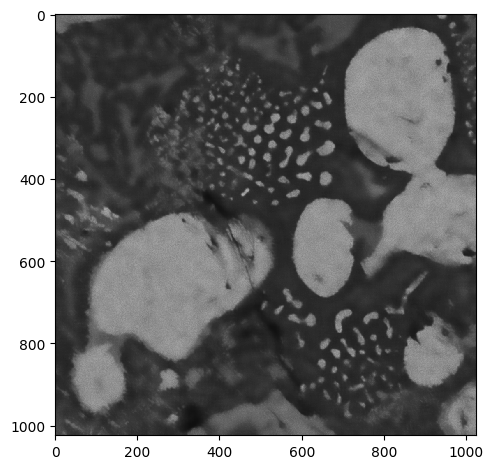

In [2]:
import cProfile
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


def slow_nl_means(img, sigma_est):
    return denoise_nl_means(img, h=1.15 * sigma_est)

cell_img_1 = img_as_float(imread("C:\\Users\\marti\\SCHOOL\\pv162-project\\data\\img_1.png"))
#C:\Users\marti\SCHOOL\pv162-project\data\img_1.png

sigma = 0.08
noisy = random_noise(cell_img_1, var=sigma**2)
sigma_est = np.mean(estimate_sigma(noisy, channel_axis=-1))

print(f'estimated noise standard deviation = {sigma_est}')
#imshow(noisy)
print(noisy.ndim)
print(noisy.shape)
print(noisy[0][0], noisy[1000][1000])

astro = img_as_float(data.astronaut())
print(astro.ndim)
print(astro.shape)

# a = np.zeros((40, 40))
# a[10:-10, 10:-10] = 1.
# rng = np.random.default_rng()
# a += 0.3 * rng.standard_normal(a.shape)
# print(a.ndim)
# print(a.shape)
# denoised_a = denoise_nl_means(a, 7, 5, 0.1)

denoised = slow_nl_means(noisy, sigma_est)
#imshow(noisy)
imshow(denoised)
# cProfile.run('slow_nl_means(noisy, sigma_est)')

